In [18]:
%run "../Eigendecomposition_Source_Code.ipynb"

Loading: Eigendecomposition_Source_Code.ipynb...
Done at: 2023/08/21 16:47:08


In [26]:
%run "../code/Basics_Source_Code.ipynb"

	Loading analysis source code...
	Done!


In [21]:
sd = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_s1_curated.zip')

/tmp/ipykernel_2315541/1918512282.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_s1_curated.zip')


In [20]:
import pickle
file = open('/home/jovyan/work/Human_Hippocampus/5-10-23s1-CutData.pkl', 'rb')
snipped = pickle.load(file)
file.close()

## Helpers

In [54]:
def raster_analysis_bounds(sd, xsize=10, ysize=6, start_time=0, stop_time=None, save_path=None):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)  # in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

    # Determine the stop_time if it's not provided
    if stop_time is None:
        stop_time = t[-1]

    # Filter times and idces within the specified start and stop times
    mask = (times >= start_time * 1000) & (times <= stop_time * 1000)
    times = times[mask]
    idces = idces[mask]

    fig, ax = plt.subplots(figsize=(xsize, ysize))

    ax.scatter(times / 1000, idces, marker='|', s=1)
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='r')

    ax.set_xlim(start_time, stop_time)
    ax.set_title("Raster Plot")
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
        
### --------------------------------------------------------------------------------------------

def createPlots2(sd):
    # creates plots for spikedata analysis including: ISI hist, firing rate hist and layout, and Spikeraster of first 30 seconds
    firing_rates = calculate_mean_firing_rates(sd)
    seconds=30 # seconds to display raster
    neuron_x = []
    neuron_y = []
    
    for neuron in sd.neuron_data[0].values():
        neuron_x.append(neuron["position"][0])
        neuron_y.append(neuron["position"][1])
    
    # Plot main figure --------------------------------------------------------------------
    figs, plots = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
    figs.suptitle(f"Plots of snipped recording:", ha="center")
    
    # Plot ISI Histogram subplot
    plots[0,0].hist(ISI(sd), bins=50);
    plots[0,0].set_title("Interspike Interval of Recording")
    plots[0,0].set_xlabel("Time bin(ms)")
    plots[0,0].set_ylabel("ISI count")
    
    # Plot Firing Rates Histogram subplot
    plots[0,1].hist(firing_rates);
    plots[0,1].set_title("Average Firing Rate for Neural Units") 
    plots[0,1].set_xlabel("Firing Rate(ms)")
    plots[0,1].set_ylabel("Unit Count") 
    
    # Plot Neuron Firing Rate Layout subplot
    plots[1,0].scatter(neuron_x, neuron_y, s=firing_rates*100, c="red", alpha=0.3)
    #plots[1,0].scatter(neuron_x, neuron_y, s=(2**firing_rates)*10, c="red", alpha=0.3)
    plots[1,0].set_title("Neuron Firing Rate Across MEA")
    plots[1,0].set_xlabel("um")
    plots[1,0].set_ylabel("um")
    #plots[3] = Firing_Rate_Layout(sd);
    
    
    # Plot Raster with plotted firing rate over time subplot
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()
    
    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000
    
    plots[1,1].scatter(times/1000,idces,marker='|',s=1)
    plots2 = plots[1,1].twinx()
    plots2.plot(t,pop_rate_smooth,c='r')

    plots[1,1].set_xlim(0,seconds)
    plots[1,1].set_title("Spike Raster Analysis")
    plots[1,1].set_xlabel("Time(s)")
    plots[1,1].set_ylabel("Unit #")
    plots2.set_ylabel("Firing Rate")
    
    # Plot second figure ------------------------------------------------------------------
    figs2, axs = plt.subplots(nrows=2,ncols=4,figsize=(30,10)) 
    figs2.suptitle(f"Interspike Interval of Individual Neural Units of Snipped Data")
    
    for i in range(8): # Plot individual ISI figures
        if(i < sd.N):
            if i < 4: # First Row
                axs[0,i].hist(IndivISI(sd, i))
                axs[0,i].set_title(f"Interspike Interval of Neural Unit {i}")
                axs[0,i].set_xlabel("Time bin(ms)")
                axs[0,i].set_ylabel("ISI count")
            else: # Second Row
                axs[1,i-4].hist(IndivISI(sd, i))
                axs[1,i-4].set_title(f"Interspike Interval of Neural Unit {i}")
                axs[1,i-4].set_xlabel("Time bin(ms)")
                axs[1,i-4].set_ylabel("ISI count")
        else: # Print warning title in case neuron count is uner 8
            figs2.suptitle(f"Interspike Interval of Individual Neural Units of File {filename}\n Note: Neuron Count Under 8 ({sd.N})")
            
def EigenLayoutsDisplay(sd, showamount=5):
    corr = correlation(sd)
    sttc = get_sttc(sd)
    Wcorr, Ucorr = eigenvalues_eigenvectors(corr)
    Wsttc, Usttc = eigenvalues_eigenvectors(sttc)
    
    #firing_rates = calculate_mean_firing_rates(sd)
    
    neuron_x = []
    neuron_y = []
    
    for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array
        neuron_x.append(neuron['position'][0])

        neuron_y.append(neuron['position'][1])
        
    figs, axs = plt.subplots(nrows=2,ncols=showamount,figsize=(12*showamount,12))
    figs.suptitle("First Five Eigenvector Layouts")
    
    for i in range(showamount):
        pltA = axs[0,i].scatter(neuron_x,neuron_y, c=Ucorr[:,i], cmap = plot_color)
        #pltA = axs[0,i].scatter(neuron_x,neuron_y, s=firing_rates*20, c=Ucorr[:,i], cmap = plot_color)
        axs[0,i].set_title(f"Corr Eigenvector #{i+1}")
        axs[0,i].set_xlabel("um")
        axs[0,i].set_ylabel("um")
        axs[0,i].set_facecolor("grey")
        figs.colorbar(pltA, ax=axs[0,i], label="Eigen component value")
        
        pltB = axs[1,i].scatter(neuron_x,neuron_y, c=Usttc[:,i], cmap = plot_color)
        #pltB = axs[1,i].scatter(neuron_x,neuron_y, s=firing_rates*20, c=Usttc[:,i], cmap = plot_color)
        axs[1,i].set_title(f"STTC Eigenvector #{i+1}")
        axs[1,i].set_xlabel("um")
        axs[1,i].set_ylabel("um")
        axs[1,i].set_facecolor("grey")
        figs.colorbar(pltB, ax=axs[1,i], label="Eigen component value")
        
def EigenDirection(sd, selection):
    #corr = correlation(sd)
    sttc = get_sttc(sd)
    #Wcorr, Ucorr = eigenvalues_eigenvectors(corr)
    Wsttc, Usttc = eigenvalues_eigenvectors(sttc)
    
    neuron_x = []
    neuron_y = []
    
    for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array
        neuron_x.append(neuron['position'][0])

        neuron_y.append(neuron['position'][1])
        
    plt.figure(figsize=(7,5)) 
    ax = plt.axes()
    ax.set_facecolor("grey")
    
    
    plt.scatter(neuron_x,neuron_y, c=Usttc[:,selection], cmap = plot_color) # color each plotted neuron according to the values of the eigenvector
    """
    ####----------------------------------------------------------
    #
    # INSERT ARROW CODE HERE
    #
    ####----------------------------------------------------------
    
    direction_threshold = 0.65
    
    for pair, entries in pairs_lates_directed.items():
        lates_i = np.array(entries)

        if len(lates_i) == 0:
            continue

        percent_neg = np.sum(lates_i < 0) / len(lates_i)
        percent_pos = np.sum(lates_i > 0) / len(lates_i)

        # Check the direction and conditions
        is_pos = np.median(lates_i) > 0
        if is_pos and percent_pos > direction_threshold:
            start_i = pair[0]
            end_i = pair[1]

            arrow_color = "black"
            alpha_upd = 0
#             if neuron_y[start_i] < 500 or neuron_y[end_i] < 500:
#                 arrow_color = "lime"
#                 alpha_upd = 0.7

            if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
                arrow_color = "r"
                alpha_upd = 0.7

            if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
                arrow_color = "blue"
                alpha_upd = 0.7

            arrow = FancyArrow(
                neuron_x[end_i], neuron_y[end_i],
                neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
                length_includes_head=True, head_width=25,
                linewidth=1, color=arrow_color, alpha=alpha_upd, edgecolor=arrow_color, facecolor=arrow_color)
            plt.gca().add_patch(arrow)"""
    
    plt.xlabel('um')
    plt.ylabel('um')
    plt.colorbar(label="Eigen Component Value")
    plt.title("Eigenvector & Directionality")
    
    return

## Rasters

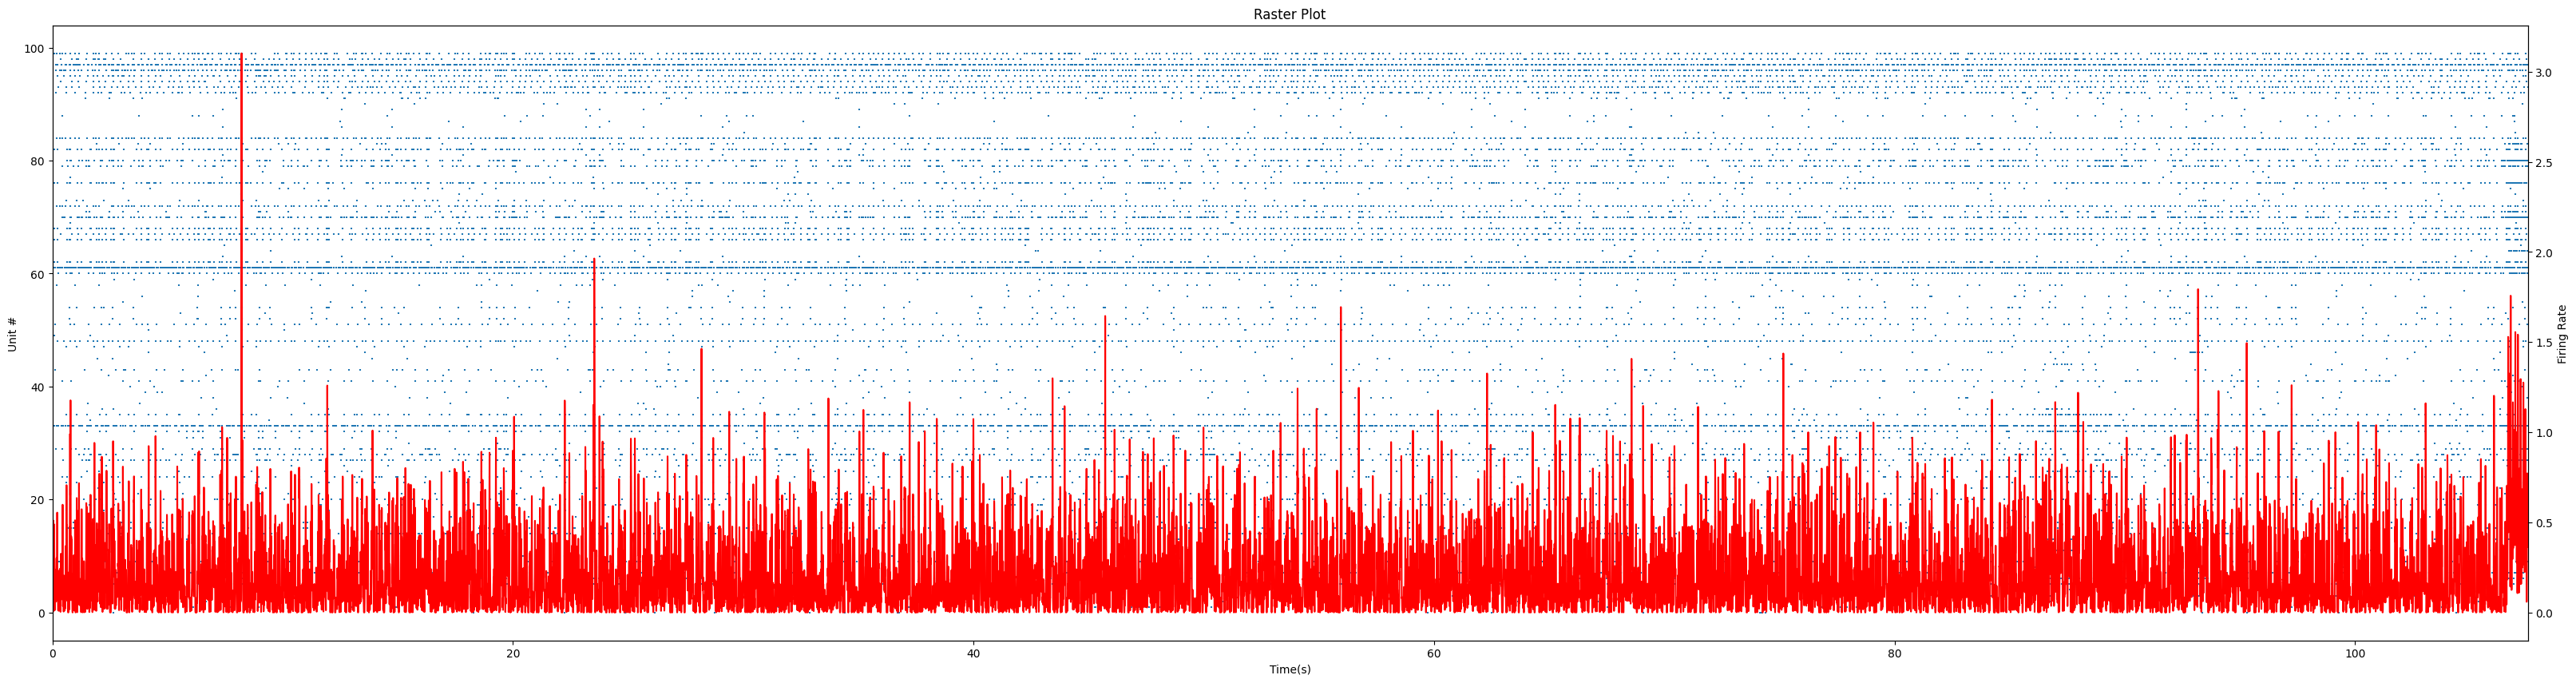

In [33]:
raster_analysis_bounds(sd, xsize=40, ysize=10)

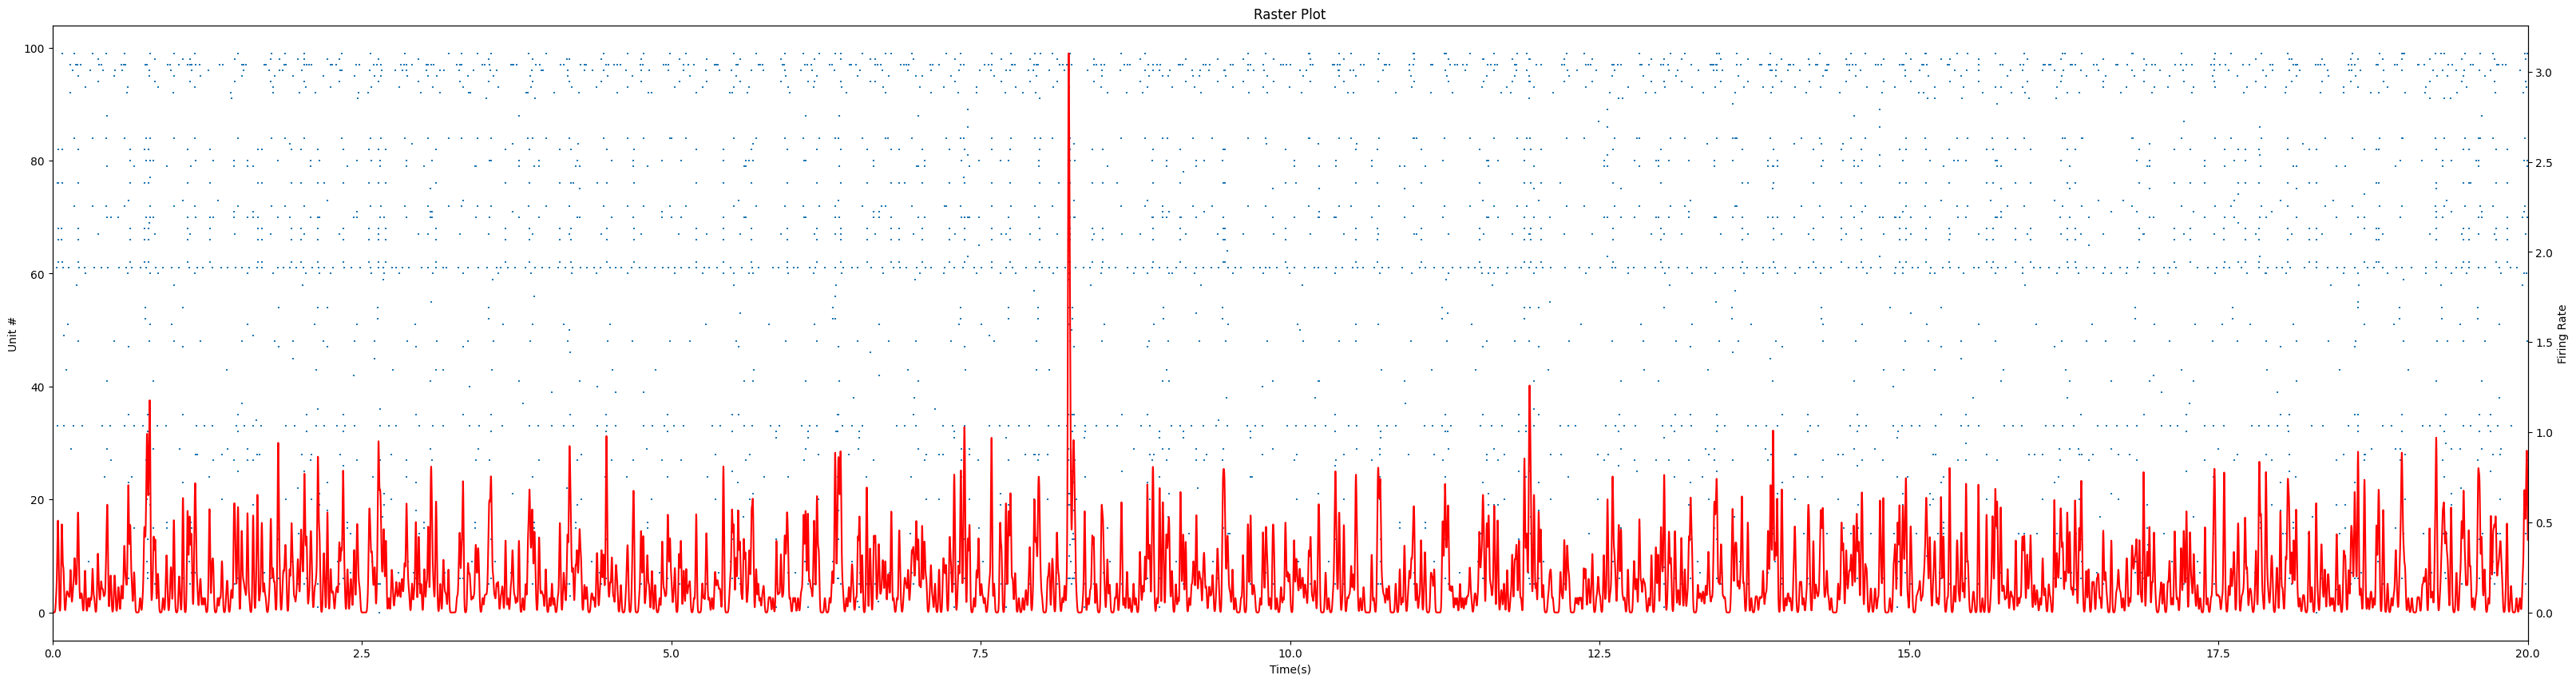

In [10]:
raster_analysis_bounds(sd, xsize=40, ysize=10, start_time=0, stop_time=20)

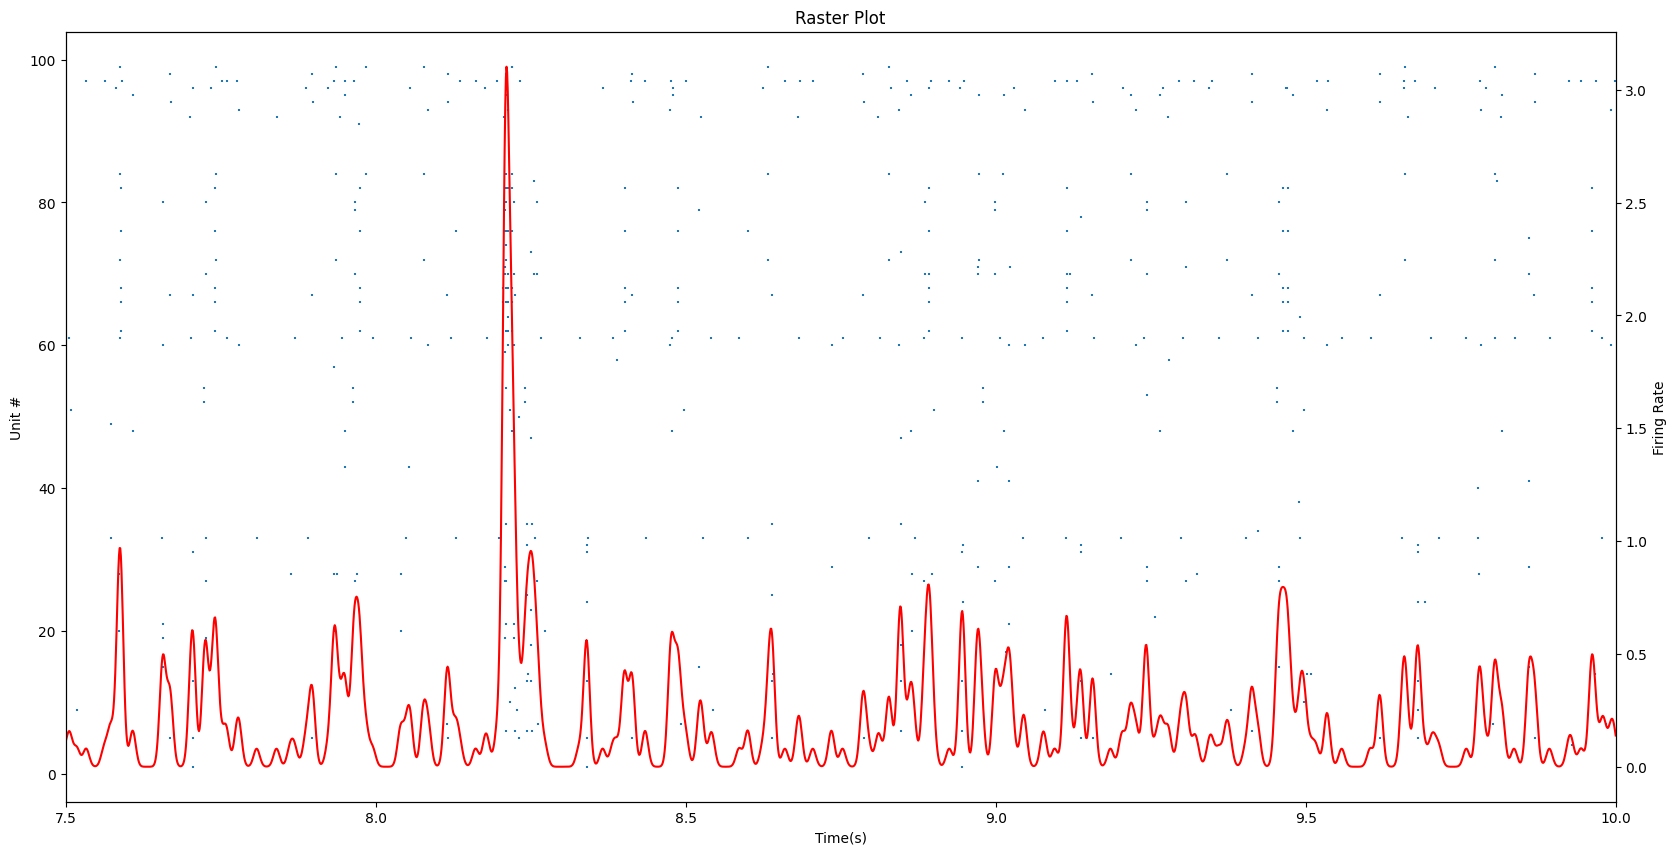

In [16]:
raster_analysis_bounds(sd, xsize=20, ysize=10, start_time=7.5, stop_time=10)

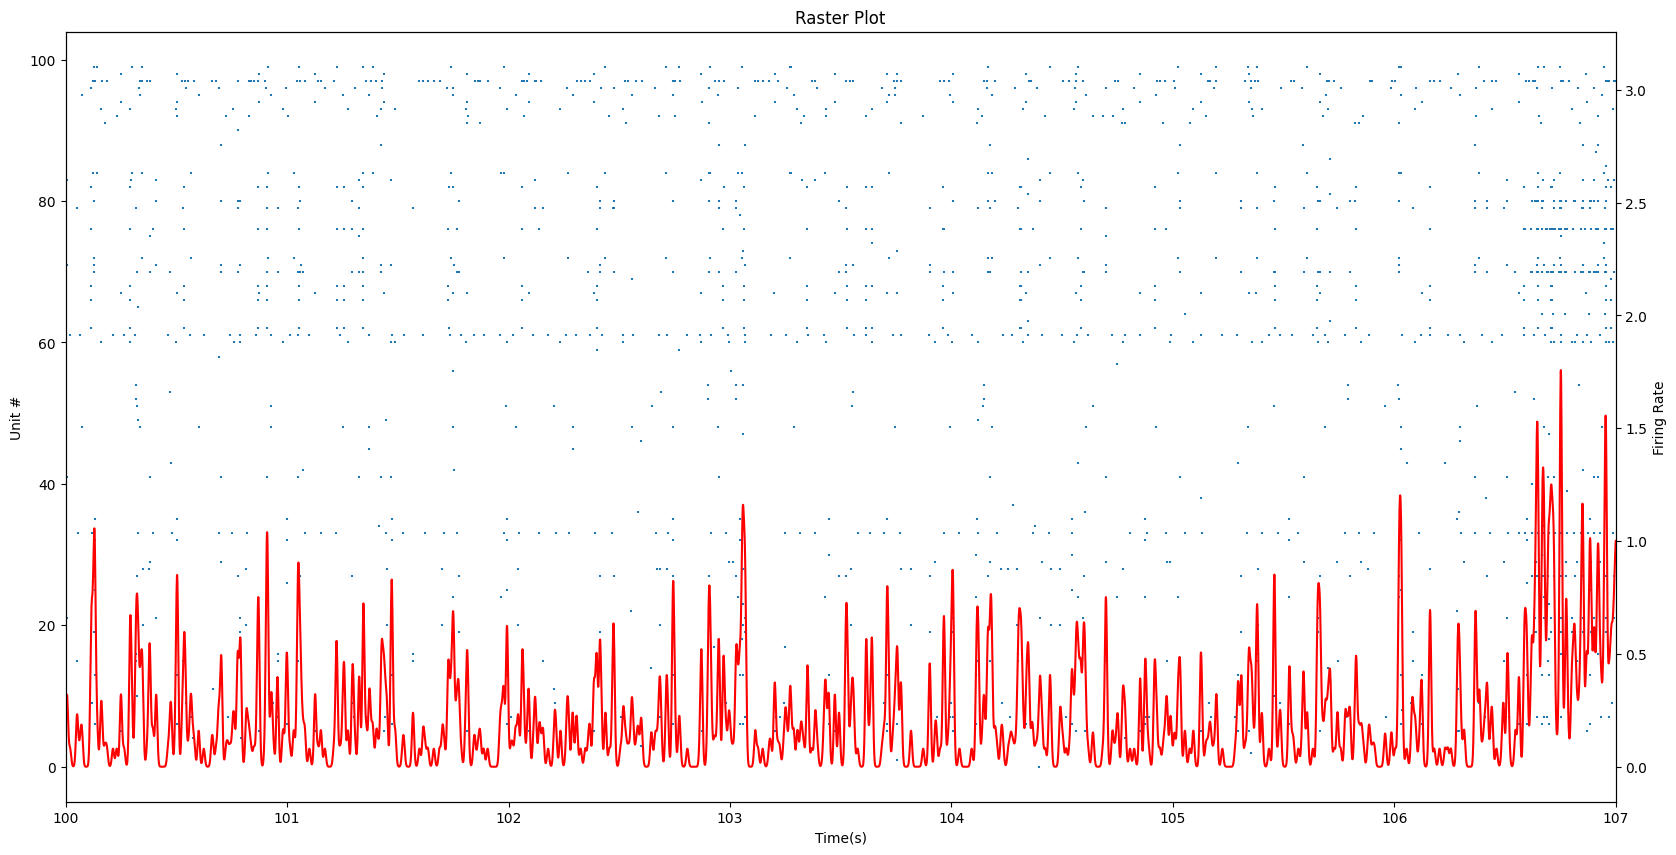

In [15]:
raster_analysis_bounds(sd, xsize=20, ysize=10, start_time=100, stop_time=107)

## Work

/tmp/ipykernel_2315541/2832556360.py:48: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


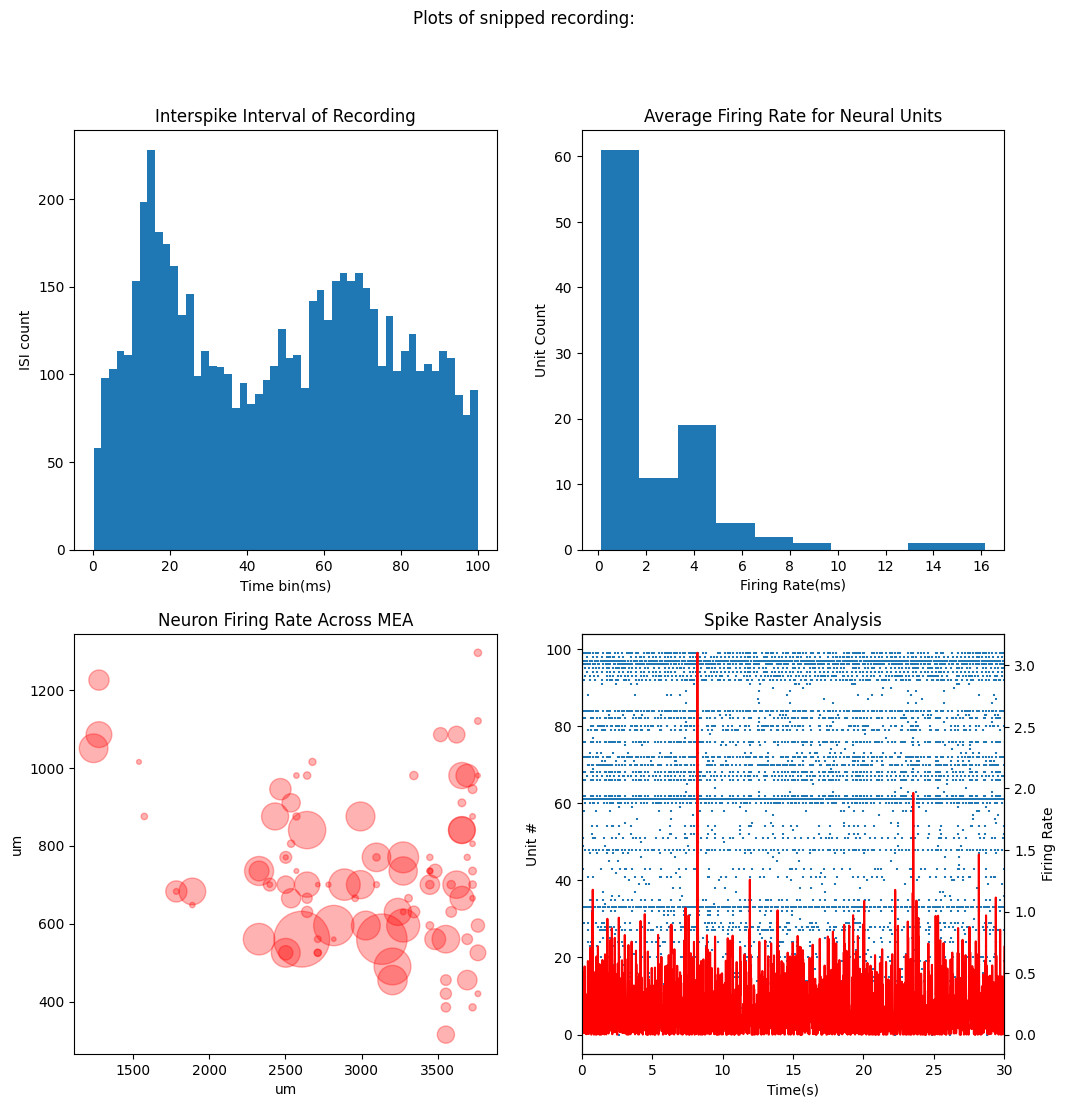

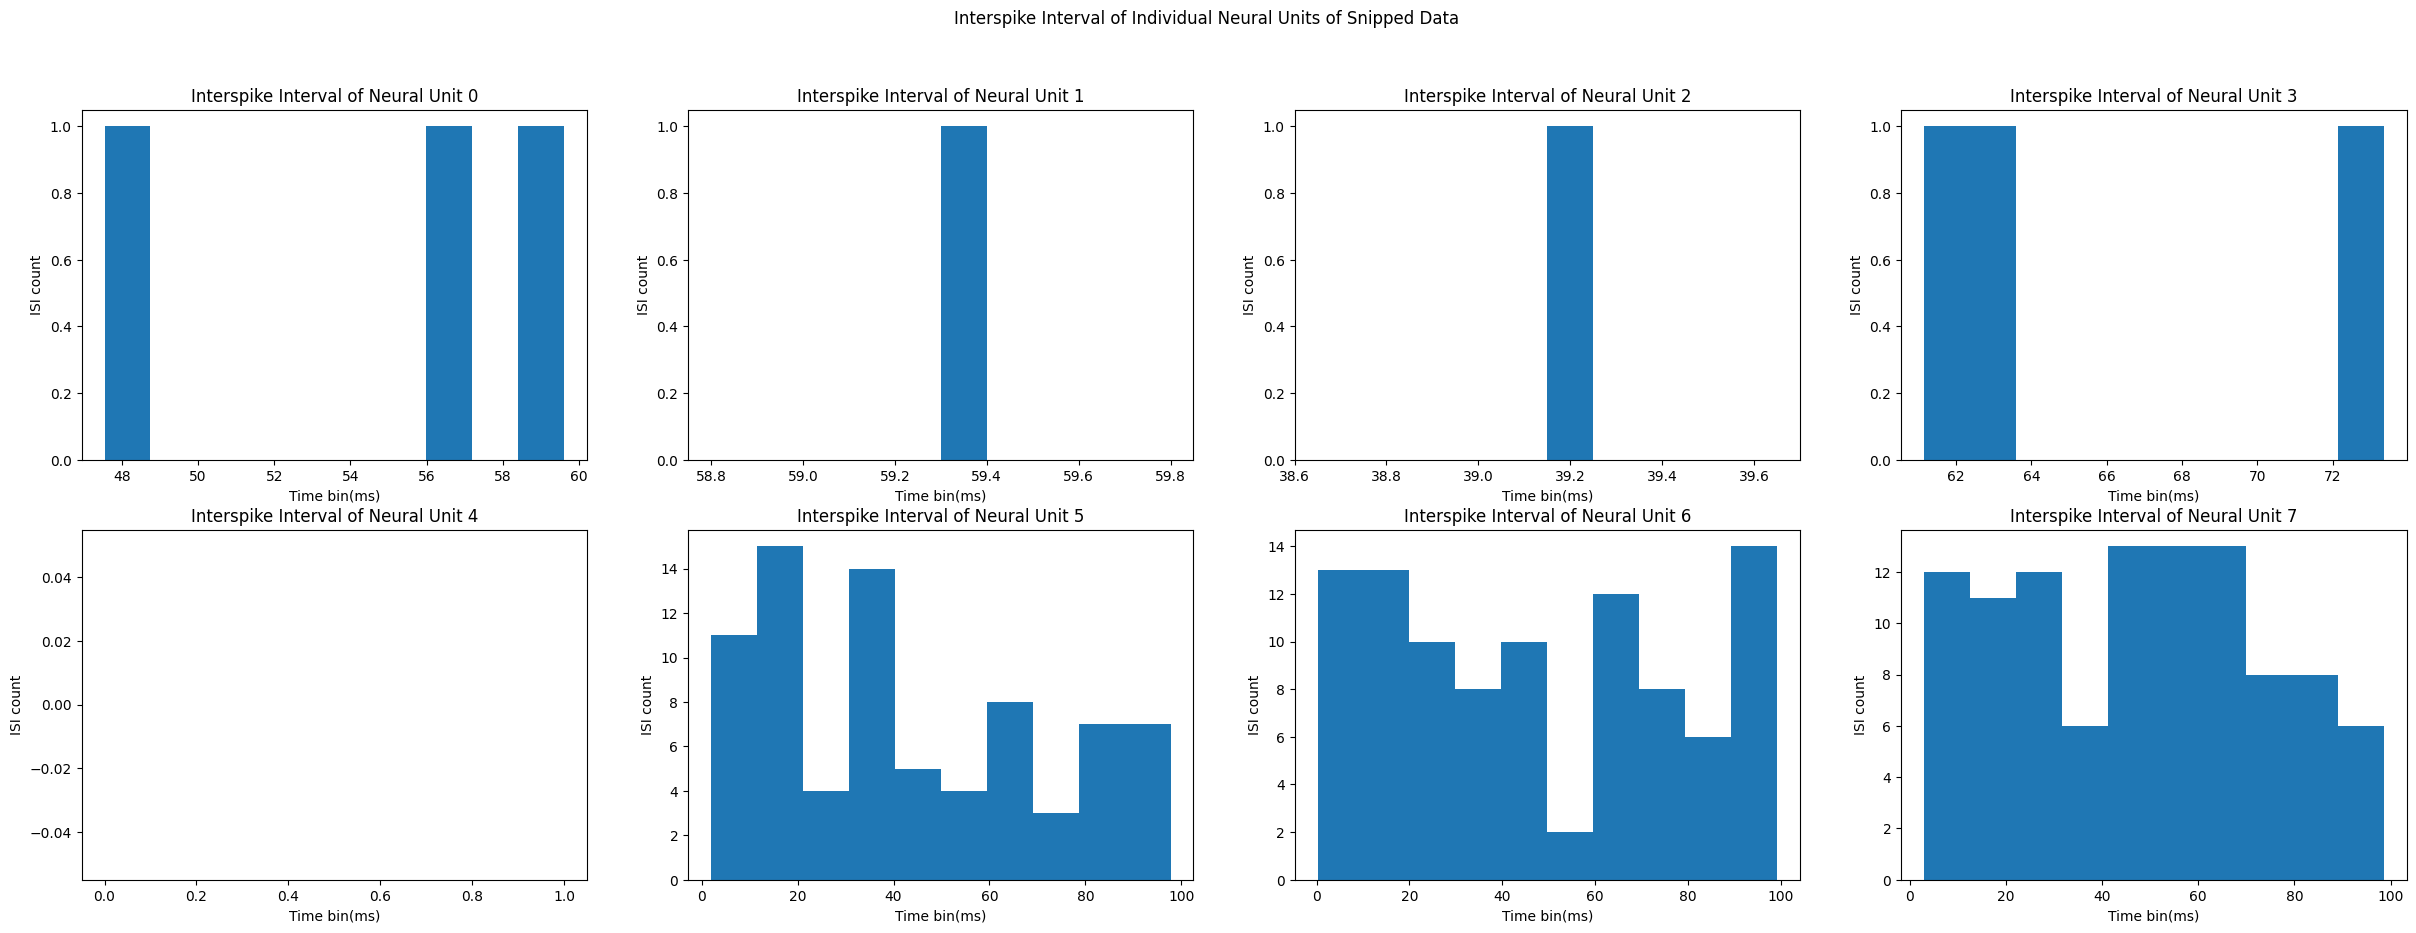

In [34]:
createPlots2(snipped)

deeper analysis: 

In [35]:
Corr = correlation(snipped)
STTC = get_sttc(snipped)
Toep = toeplitz(Corr)
    
Wcorr, Ucorr = eigenvalues_eigenvectors(Corr)
Wsttc, Usttc = eigenvalues_eigenvectors(STTC)
Wt, Ut = eigenvalues_eigenvectors(Toep)

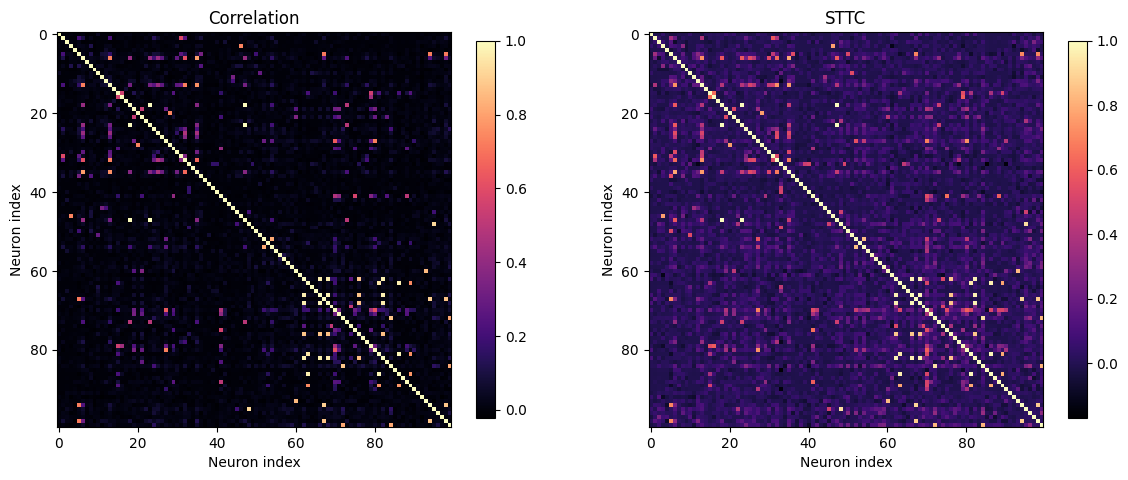

In [36]:
corrMethPlots(Corr, STTC)

In [1]:
flatSTTC = STTC.flatten()
plt.hist(flatSTTC, bins=40)
plt.xlim(-0.2, 0.4)
plt.show()

NameError: name 'STTC' is not defined

### <font color="brown">Unsnipped Check

In [37]:
Corr2 = correlation(sd)
STTC2 = get_sttc(sd)
Toep2 = toeplitz(Corr2)
    
Wcorr2, Ucorr2 = eigenvalues_eigenvectors(Corr2)
Wsttc2, Usttc2 = eigenvalues_eigenvectors(STTC2)
Wt2, Ut2 = eigenvalues_eigenvectors(Toep2)

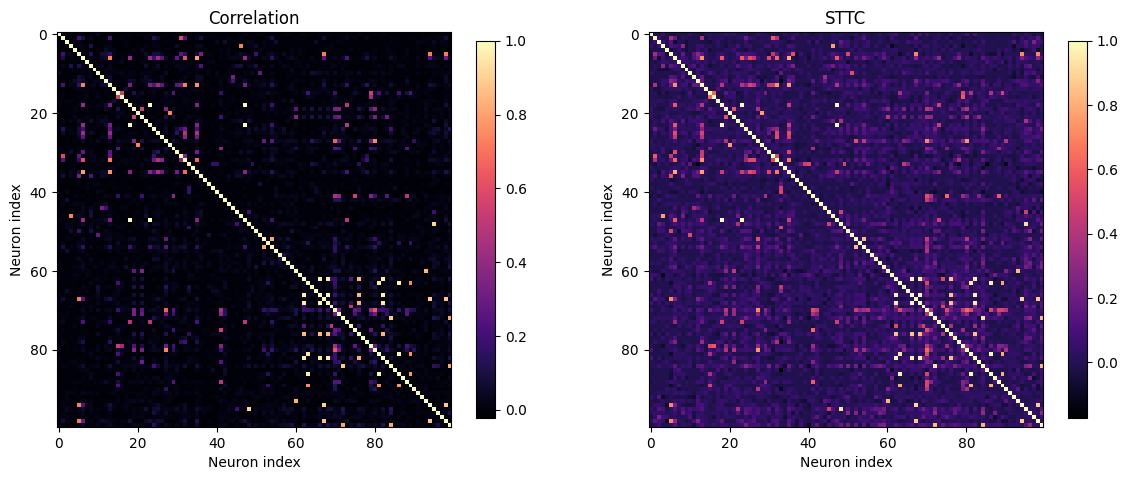

In [38]:
corrMethPlots(Corr2, STTC2)

## Eigen

/tmp/ipykernel_2315541/3155277207.py:128: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array


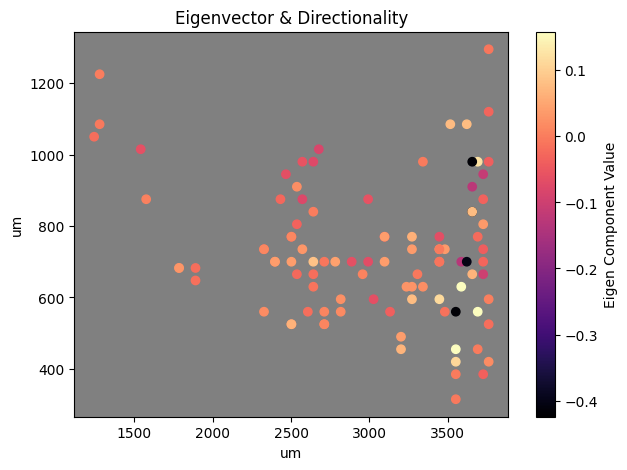

In [52]:
EigenDirection(snipped, 4)

/tmp/ipykernel_2315541/284051838.py:129: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array


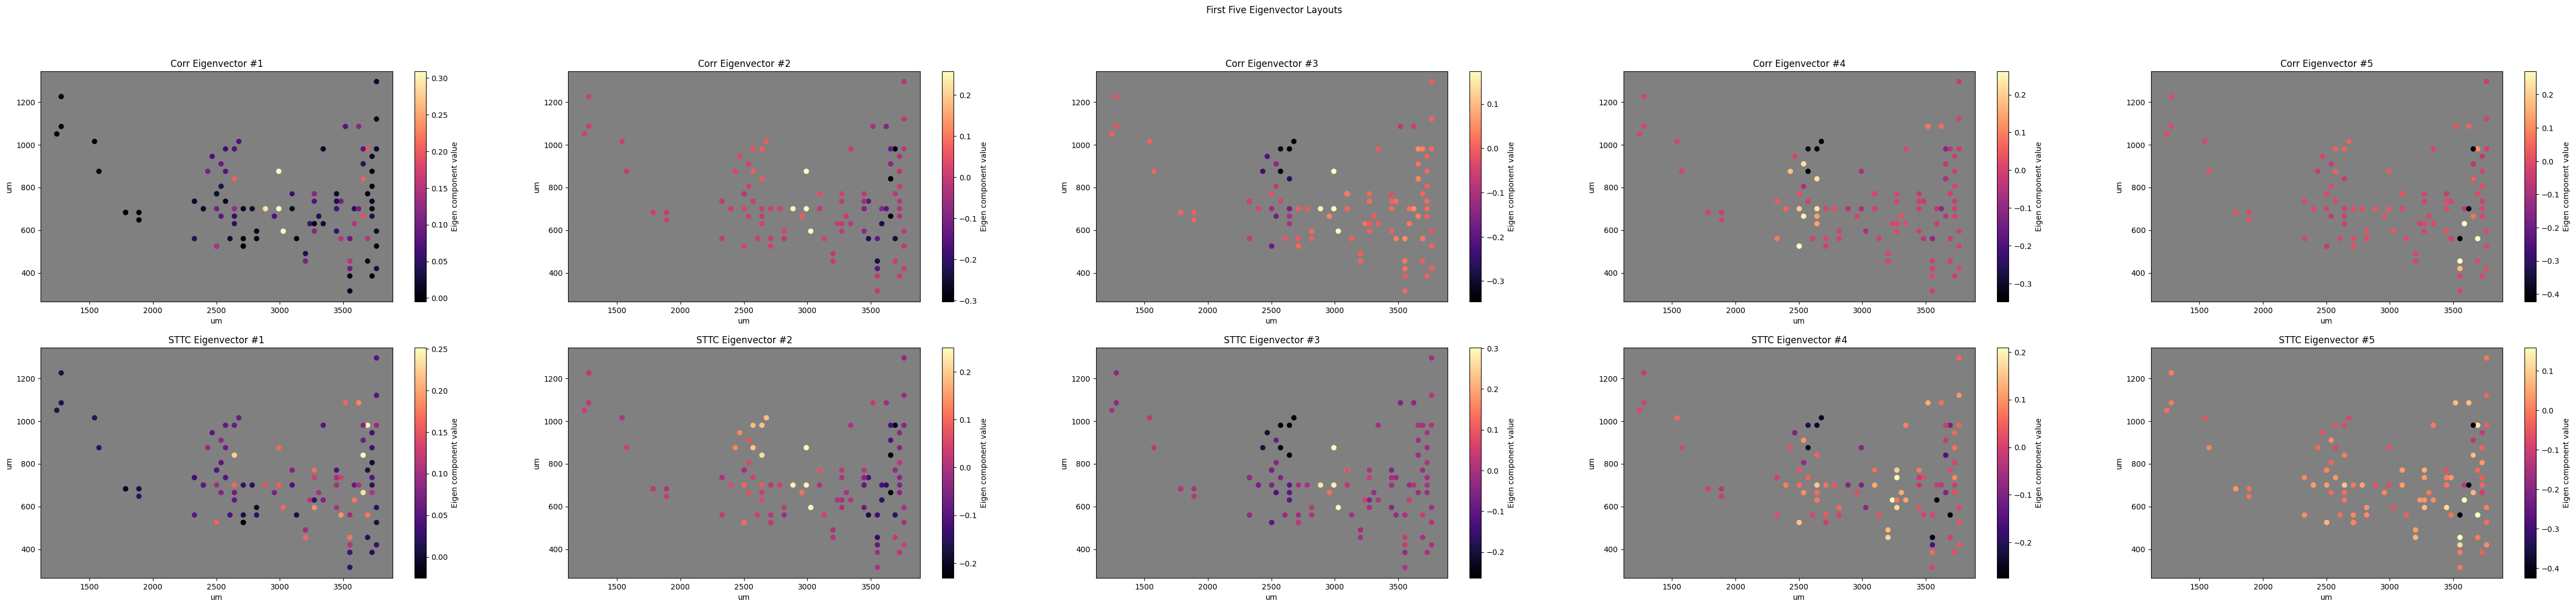

In [55]:
EigenLayoutsDisplay(snipped)